# Introduction

Penipuan asuransi adalah aktivitas ilegal dan tidak etis yang dilakukan secara sistematis demi keuntungan finansial. Ini adalah masalah kritis bagi perusahaan asuransi karena menyebabkan pengeluaran miliaran dolar yang tidak perlu setiap tahunnya. Fenomena ini masih belum tertangani secara optimal. Proses identifikasi yang ada saat ini masih menggunakan pendekatan tradisional yang memakan waktu lama dan kurang memadai. Oleh karena itu, perusahaan asuransi memerlukan cara yang lebih efektif untuk mengatasi masalah ini. Salah satu solusinya adalah penerapan machine learning dalam pendeteksiannya.

Objektif:

Bangun model pembelajaran mesin untuk mendeteksi apakah klaim asuransi merupakan Penipuan atau Bukan.

# Import Library

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [79]:
df = pd.read_csv('insurance_claims.csv')
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


# Data Understanding

- Dataset ini memiliki berbagai jenis kolom, termasuk numerik dan kategorikal.
- Kolom-kolom seperti months_as_customer, age, policy_number, dan sebagainya memberikan informasi tentang pelanggan dan polis asuransi mereka.
- Ada kolom untuk informasi klaim seperti total_claim_amount, injury_claim, property_claim, dan vehicle_claim.
- Kolom fraud_reported tampaknya menjadi target untuk prediksi kita, dengan nilai 'Y' atau 'N' yang menunjukkan apakah klaim itu curang atau tidak.
- Terdapat kolom yang tampaknya tidak relevan atau tidak lengkap, seperti _c39.

In [80]:
# kita dapat menghapus kolom _c39 karena tidak relevan dan terdapat banyak missing values

df.drop(columns=['_c39'], axis=1, inplace=True)

## Replacing Nan Values

In [81]:
# kita dapat melihat beberapa nilai yang hilang yang dilambangkan dengan '?' jadi mari kita ganti nilai yang hilang dengan np.nan

df.replace('?', np.nan, inplace = True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [83]:
to_drop = ['policy_number','policy_bind_date','insured_zip','incident_location', 'policy_csl']

df.drop(columns=to_drop, inplace=True)

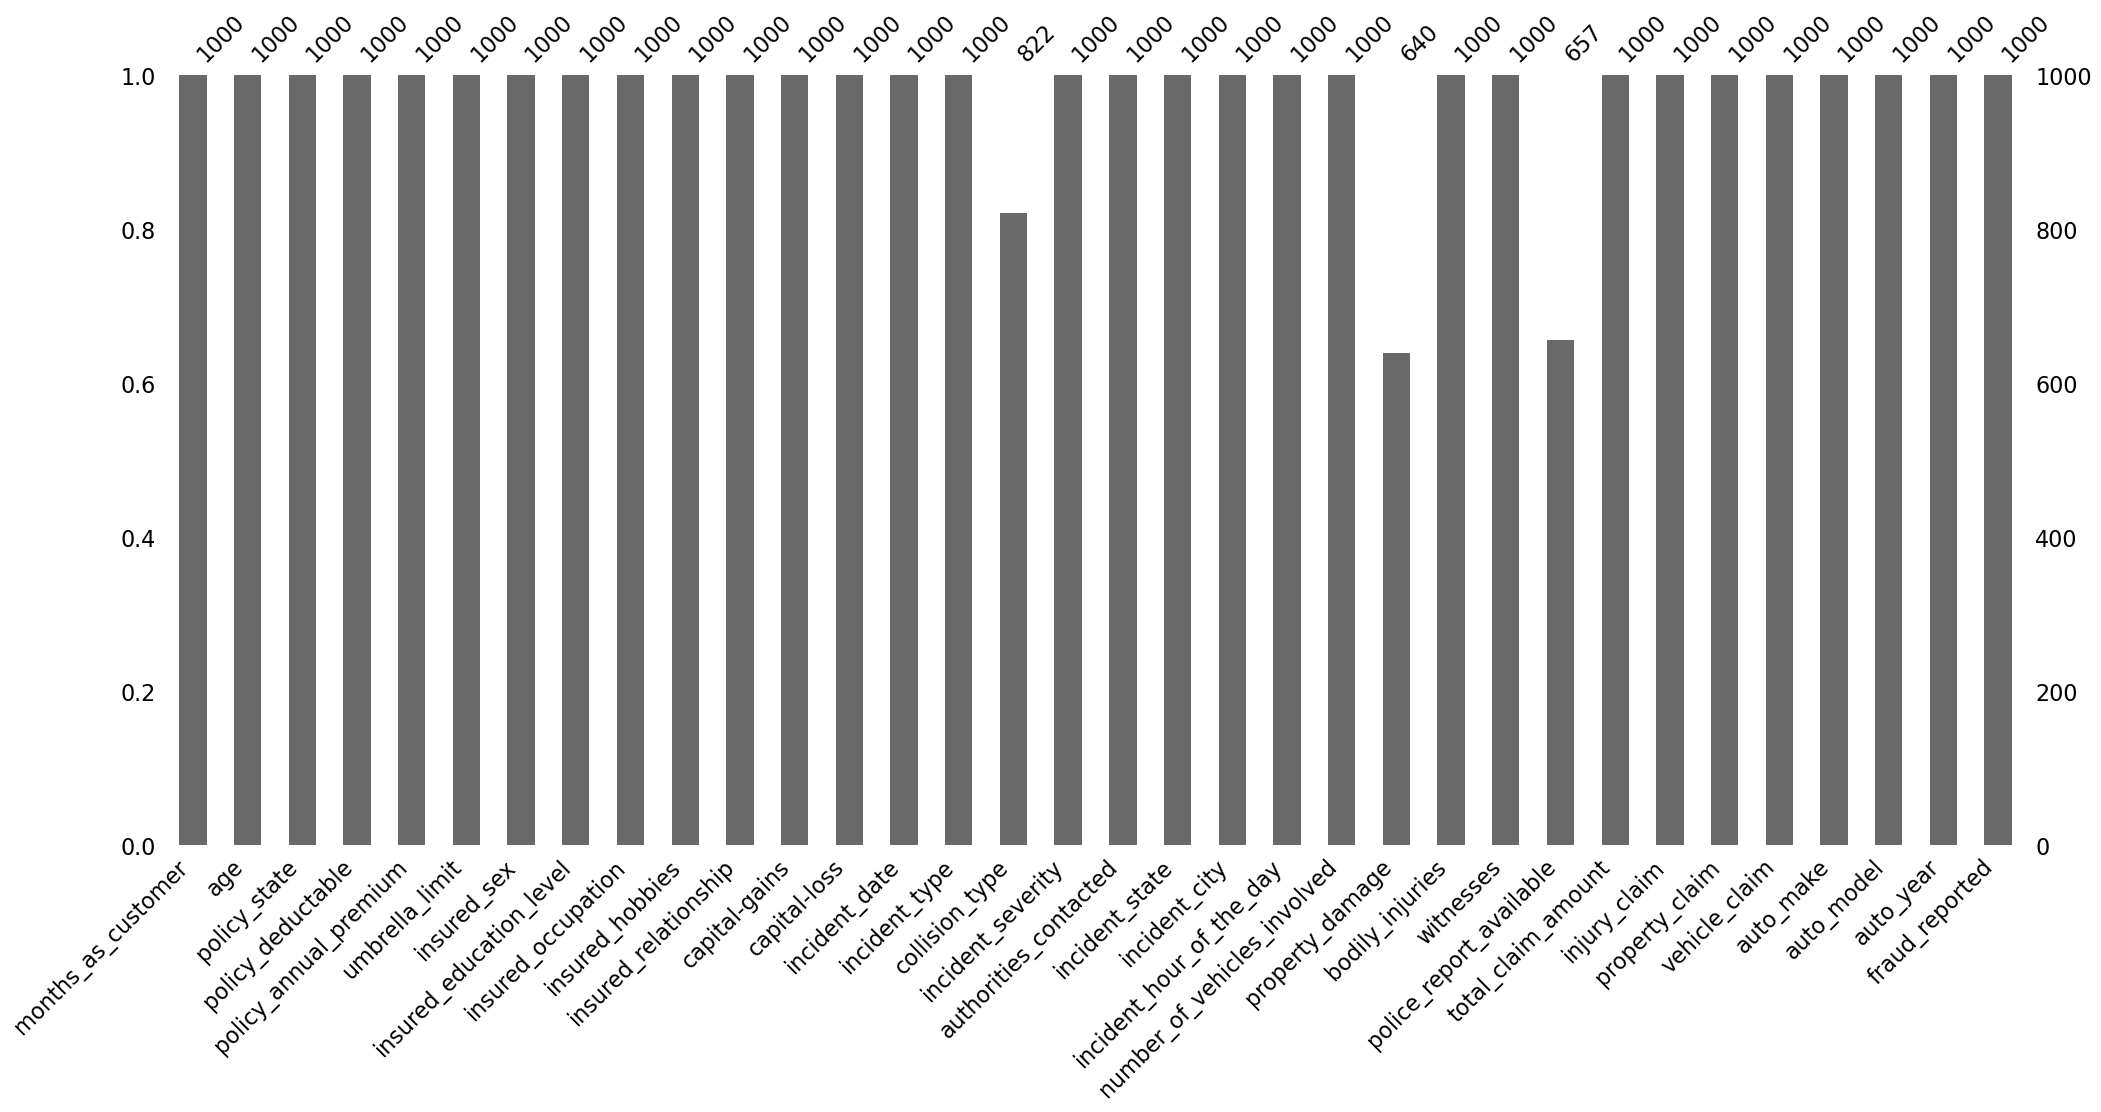

In [84]:
import missingno as msno

msno.bar(df)
plt.show()

- Terindikasi 3 variabel memiliki missing values, yaitu collision_type, property_damage, police_report_available.

## Data Imputation / Handling Missing Values

In [85]:
df['property_damage'].value_counts()

NO     338
YES    302
Name: property_damage, dtype: int64

In [86]:
df['police_report_available'].value_counts()

NO     343
YES    314
Name: police_report_available, dtype: int64

In [87]:
df['collision_type'].value_counts()

Rear Collision     292
Side Collision     276
Front Collision    254
Name: collision_type, dtype: int64

Text(0.5, 1.0, 'Collision Type')

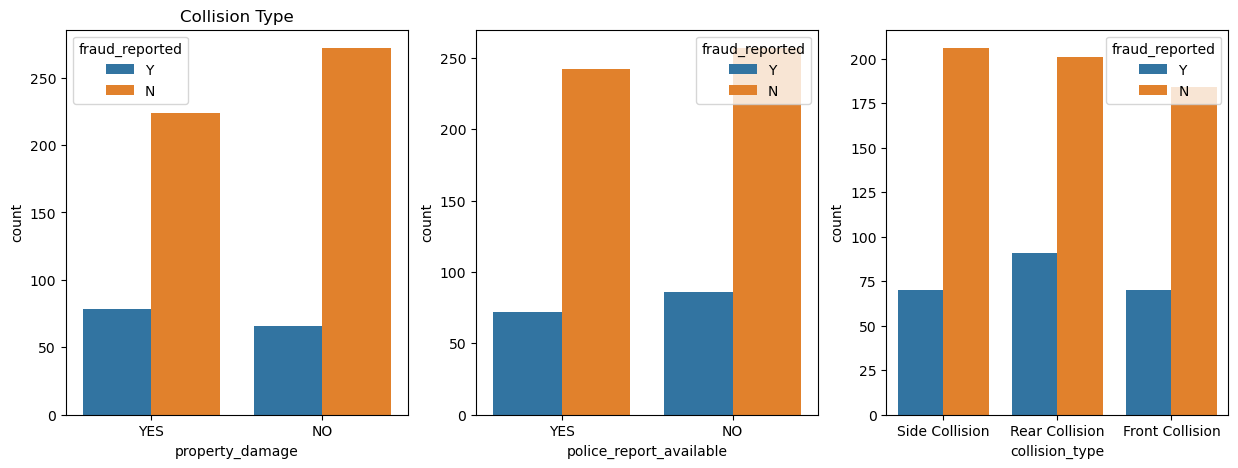

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = df, x = 'property_damage', hue=df['fraud_reported'], ax=axes[0])
axes[0].set_title('Property Damage')

sns.countplot(data = df, x = 'police_report_available',hue=df['fraud_reported'], ax=axes[1])
axes[0].set_title('Police Report Available')

sns.countplot(data = df, x = 'collision_type',hue=df['fraud_reported'], ax=axes[2])
axes[0].set_title('Collision Type')

In [89]:
df['collision_type'] = df['collision_type'].fillna(df['collision_type'].mode()[0])
df['property_damage'] = df['property_damage'].fillna(df['property_damage'].mode()[0])
df['police_report_available'] = df['police_report_available'].fillna(df['police_report_available'].mode()[0])

Text(0.5, 1.0, 'Collision Type')

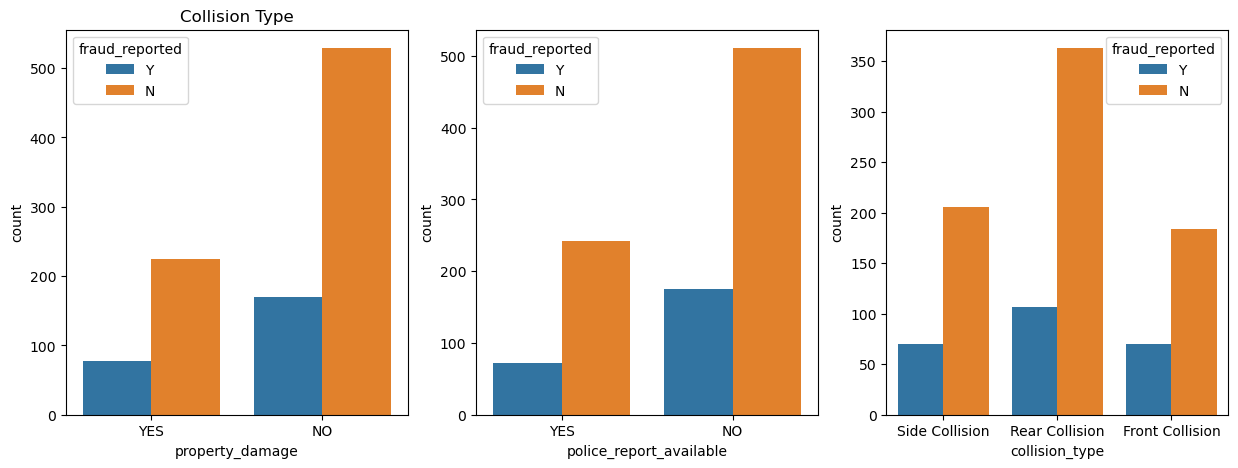

In [90]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = df, x = 'property_damage', hue=df['fraud_reported'], ax=axes[0])
axes[0].set_title('Property Damage')

sns.countplot(data = df, x = 'police_report_available',hue=df['fraud_reported'], ax=axes[1])
axes[0].set_title('Police Report Available')

sns.countplot(data = df, x = 'collision_type',hue=df['fraud_reported'], ax=axes[2])
axes[0].set_title('Collision Type')

- dilakukan imputasi data menggunakan modus untuk setiap variabel/feature

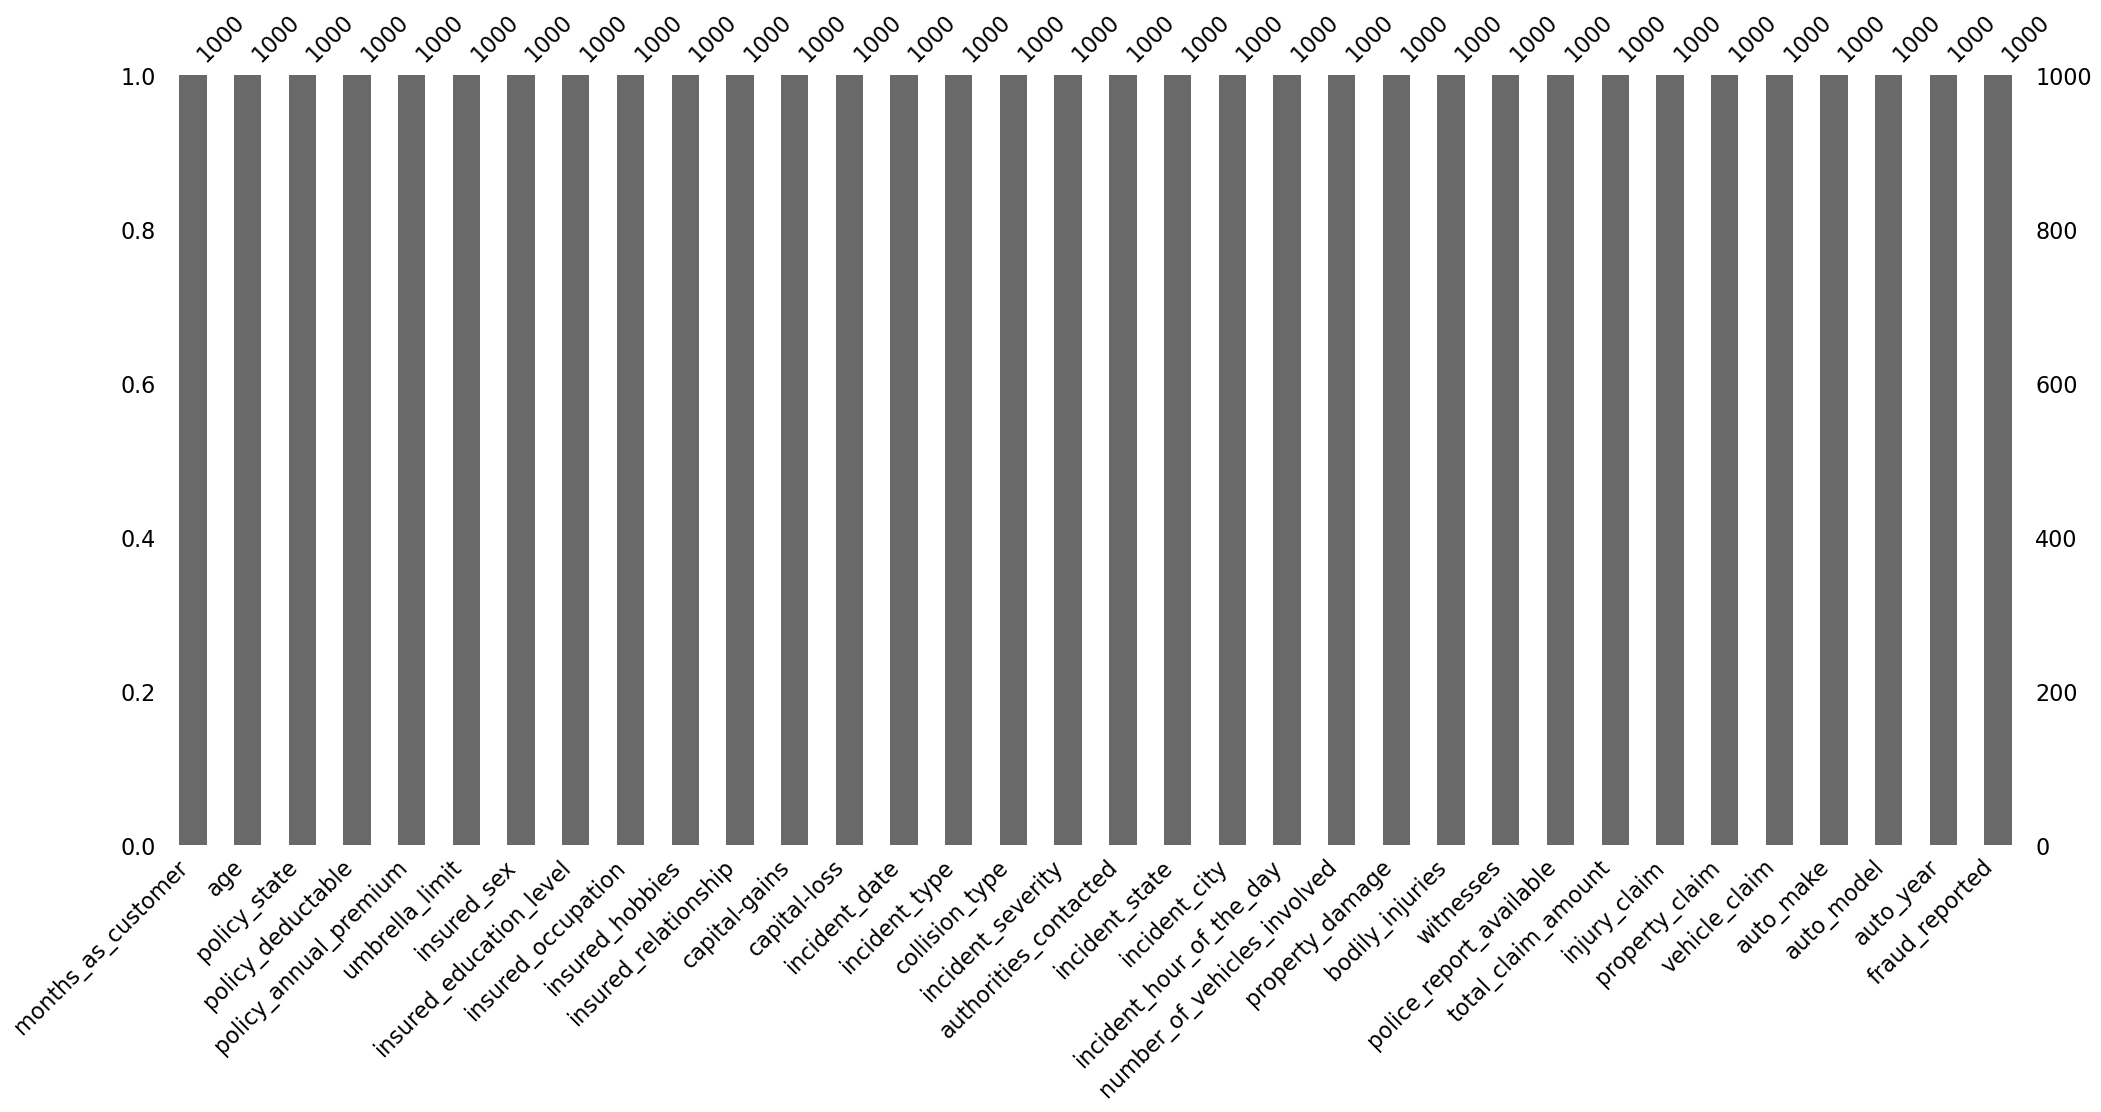

In [91]:
import missingno as msno

msno.bar(df)
plt.show()

## Check Dupliacate Data

In [92]:
df.duplicated().sum()

0

- tidak terdapat data ganda

In [93]:
df.shape

(1000, 34)

# Drop data yang tidak berkaitan dengan mobil

In [94]:
feature_drop = ['policy_annual_premium', 'insured_occupation', 'capital-loss', 'incident_hour_of_the_day', 'capital-gains', 'property_damage','property_claim','policy_state','incident_state','incident_city', 'total_claim_amount', 'injury_claim', 'policy_deductable', 'auto_model','auto_make','insured_relationship','insured_hobbies']

df.drop(columns=feature_drop, inplace=True)

# Correlation

## Korelasi Point-Biseria

Versi khusus dari korelasi Pearson yang digunakan ketika satu variabel adalah biner kategorik dan yang lainnya adalah numerik.


In [95]:
from scipy.stats import pointbiserialr, ttest_ind

# Fungsi untuk melakukan Point-Biserial Correlation
def point_biserial_correlation(data, numeric_col, binary_col):
    corr, p_value = pointbiserialr(data[numeric_col], data[binary_col].apply(lambda x: 1 if x == 'Y' else 0))
    print(f"Point-Biserial Correlation - {numeric_col} vs {binary_col}:")
    print(f"Correlation: {corr}, P-value: {p_value}")
    print("")

# Fungsi untuk melakukan Independent T-Test
def independent_t_test(data, numeric_col, binary_col):
    group1 = data[data[binary_col] == 'Y'][numeric_col]
    group2 = data[data[binary_col] == 'N'][numeric_col]
    t_stat, p_value = ttest_ind(group1, group2)
    print(f"Independent T-Test - {numeric_col} vs {binary_col}:")
    print(f"T-statistic: {t_stat}, P-value: {p_value}")
    print("")

# Variabel numerik dalam data
numerical_vars = ['months_as_customer', 'age', 'umbrella_limit', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'vehicle_claim', 'auto_year']

# Melakukan Point-Biserial Correlation dan Independent T-Test untuk setiap variabel numerik terhadap 'fraud_reported'
for var in numerical_vars:
    point_biserial_correlation(df, var, 'fraud_reported')
    independent_t_test(df, var, 'fraud_reported')



Point-Biserial Correlation - months_as_customer vs fraud_reported:
Correlation: 0.020543512494971494, P-value: 0.5164037490553159

Independent T-Test - months_as_customer vs fraud_reported:
T-statistic: 0.6491299307140105, P-value: 0.5164037490553421

Point-Biserial Correlation - age vs fraud_reported:
Correlation: 0.012143362366660013, P-value: 0.7013189051151458

Independent T-Test - age vs fraud_reported:
T-statistic: 0.38365092414841734, P-value: 0.7013189051151347

Point-Biserial Correlation - umbrella_limit vs fraud_reported:
Correlation: 0.05862165764044456, P-value: 0.06387450991600067

Independent T-Test - umbrella_limit vs fraud_reported:
T-statistic: 1.855115169877686, P-value: 0.0638745099160087

Point-Biserial Correlation - number_of_vehicles_involved vs fraud_reported:
Correlation: 0.05183867861498749, P-value: 0.10135198067763725

Independent T-Test - number_of_vehicles_involved vs fraud_reported:
T-statistic: 1.6398476711548737, P-value: 0.10135198067764085

Point-Biser

## Chi square 

meilihat hubungan variabel independen terhadap variabel dependen yaitu fraud reported

In [96]:
from scipy.stats import chi2_contingency

# Fungsi untuk melakukan uji Chi-Square dan mencetak hasilnya
def chi_square_test(data, col, target):
    contingency_table = pd.crosstab(data[col], data[target])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    print(f"Uji Chi-Square untuk '{col}' vs '{target}':")
    print(f"Chi2 Statistik: {chi2}, P-value: {p}, Degrees of Freedom: {dof}")
    print("Hubungan Signifikan" if p < 0.05 else "Tidak Ada Hubungan Signifikan")
    print("")

# Variabel kategorik yang akan diuji
categorical_vars = ['insured_sex', 'insured_education_level', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'police_report_available']

# Melakukan uji Chi-Square untuk setiap variabel kategorik terhadap 'fraud_reported'
for var in categorical_vars:
    chi_square_test(df, var, 'fraud_reported')


Uji Chi-Square untuk 'insured_sex' vs 'fraud_reported':
Chi2 Statistik: 0.8149820820596481, P-value: 0.36665138406877407, Degrees of Freedom: 1
Tidak Ada Hubungan Signifikan

Uji Chi-Square untuk 'insured_education_level' vs 'fraud_reported':
Chi2 Statistik: 1.6882273540205779, P-value: 0.9460265140372582, Degrees of Freedom: 6
Tidak Ada Hubungan Signifikan

Uji Chi-Square untuk 'incident_type' vs 'fraud_reported':
Chi2 Statistik: 29.131539725752873, P-value: 2.1013336774786627e-06, Degrees of Freedom: 3
Hubungan Signifikan

Uji Chi-Square untuk 'collision_type' vs 'fraud_reported':
Chi2 Statistik: 2.126641822282093, P-value: 0.34530716969204184, Degrees of Freedom: 2
Tidak Ada Hubungan Signifikan

Uji Chi-Square untuk 'incident_severity' vs 'fraud_reported':
Chi2 Statistik: 264.2373497806052, P-value: 5.447033547673708e-57, Degrees of Freedom: 3
Hubungan Signifikan

Uji Chi-Square untuk 'authorities_contacted' vs 'fraud_reported':
Chi2 Statistik: 26.31975738655569, P-value: 2.72770144

In [97]:
df.head()

,months_as_customer,age,umbrella_limit,insured_sex,insured_education_level,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,vehicle_claim,auto_year,fraud_reported
0,328,48,0,MALE,MD,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,1,1,2,YES,52080,2004,Y
1,228,42,5000000,MALE,MD,2015-01-21,Vehicle Theft,Rear Collision,Minor Damage,Police,1,0,0,NO,3510,2007,Y
2,134,29,5000000,FEMALE,PhD,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,3,2,3,NO,23100,2007,N
3,256,41,6000000,FEMALE,PhD,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,1,1,2,NO,50720,2014,Y
4,228,44,6000000,MALE,Associate,2015-02-17,Vehicle Theft,Rear Collision,Minor Damage,None,1,0,1,NO,4550,2009,N


# Encoding

In [98]:
df_kategorik = df.select_dtypes(include='object')

for col in df_kategorik.columns:
    print(f"{col}: \n{df_kategorik[col].unique()}\n")

insured_sex: 
['MALE' 'FEMALE']

insured_education_level: 
['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']

incident_date: 
['2015-01-25' '2015-01-21' '2015-02-22' '2015-01-10' '2015-02-17'
 '2015-01-02' '2015-01-13' '2015-02-27' '2015-01-30' '2015-01-05'
 '2015-01-06' '2015-02-15' '2015-01-22' '2015-01-08' '2015-01-15'
 '2015-01-29' '2015-01-19' '2015-01-01' '2015-02-10' '2015-01-11'
 '2015-02-24' '2015-01-09' '2015-01-28' '2015-01-07' '2015-01-18'
 '2015-02-28' '2015-02-12' '2015-01-24' '2015-01-03' '2015-01-16'
 '2015-02-14' '2015-02-21' '2015-02-18' '2015-02-26' '2015-01-17'
 '2015-01-27' '2015-02-11' '2015-01-12' '2015-02-06' '2015-01-20'
 '2015-02-02' '2015-02-20' '2015-02-08' '2015-02-23' '2015-03-01'
 '2015-01-14' '2015-02-19' '2015-02-09' '2015-01-26' '2015-01-23'
 '2015-01-31' '2015-02-03' '2015-02-01' '2015-02-05' '2015-02-25'
 '2015-02-16' '2015-02-13' '2015-02-04' '2015-02-07' '2015-01-04']

incident_type: 
['Single Vehicle Collision' 'Vehicle Theft' 'Multi

In [99]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_values = {}

for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = le.fit_transform(df[col])
        encoded_values[col] = dict(zip(le.classes_, le.transform(le.classes_)))

encoded_values


{'insured_sex': {'FEMALE': 0, 'MALE': 1},
 'insured_education_level': {'Associate': 0,
  'College': 1,
  'High School': 2,
  'JD': 3,
  'MD': 4,
  'Masters': 5,
  'PhD': 6},
 'incident_date': {'2015-01-01': 0,
  '2015-01-02': 1,
  '2015-01-03': 2,
  '2015-01-04': 3,
  '2015-01-05': 4,
  '2015-01-06': 5,
  '2015-01-07': 6,
  '2015-01-08': 7,
  '2015-01-09': 8,
  '2015-01-10': 9,
  '2015-01-11': 10,
  '2015-01-12': 11,
  '2015-01-13': 12,
  '2015-01-14': 13,
  '2015-01-15': 14,
  '2015-01-16': 15,
  '2015-01-17': 16,
  '2015-01-18': 17,
  '2015-01-19': 18,
  '2015-01-20': 19,
  '2015-01-21': 20,
  '2015-01-22': 21,
  '2015-01-23': 22,
  '2015-01-24': 23,
  '2015-01-25': 24,
  '2015-01-26': 25,
  '2015-01-27': 26,
  '2015-01-28': 27,
  '2015-01-29': 28,
  '2015-01-30': 29,
  '2015-01-31': 30,
  '2015-02-01': 31,
  '2015-02-02': 32,
  '2015-02-03': 33,
  '2015-02-04': 34,
  '2015-02-05': 35,
  '2015-02-06': 36,
  '2015-02-07': 37,
  '2015-02-08': 38,
  '2015-02-09': 39,
  '2015-02-10': 40,

In [100]:
df['fraud_reported'].value_counts()

0    753
1    247
Name: fraud_reported, dtype: int64

# Spliting Data

In [101]:
df_model = df.copy()
X = df_model.drop(columns='fraud_reported').copy()
y = df_model['fraud_reported'].copy()

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, X_test.shape)

(800, 16) (200, 16)


In [103]:
y_train.value_counts()

0    598
1    202
Name: fraud_reported, dtype: int64

In [104]:
df.head()

,months_as_customer,age,umbrella_limit,insured_sex,insured_education_level,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,vehicle_claim,auto_year,fraud_reported
0,328,48,0,1,4,24,2,2,0,4,1,1,2,1,52080,2004,1
1,228,42,5000000,1,4,20,3,1,1,4,1,0,0,0,3510,2007,1
2,134,29,5000000,0,6,52,0,1,1,4,3,2,3,0,23100,2007,0
3,256,41,6000000,0,6,9,2,0,0,4,1,1,2,0,50720,2014,1
4,228,44,6000000,1,0,47,3,1,1,2,1,0,1,0,4550,2009,0


# Modelling Random Forest untuk melihat fitur importance

In [105]:
df_new = df.copy()
df_new.head()

,months_as_customer,age,umbrella_limit,insured_sex,insured_education_level,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,vehicle_claim,auto_year,fraud_reported
0,328,48,0,1,4,24,2,2,0,4,1,1,2,1,52080,2004,1
1,228,42,5000000,1,4,20,3,1,1,4,1,0,0,0,3510,2007,1
2,134,29,5000000,0,6,52,0,1,1,4,3,2,3,0,23100,2007,0
3,256,41,6000000,0,6,9,2,0,0,4,1,1,2,0,50720,2014,1
4,228,44,6000000,1,0,47,3,1,1,2,1,0,1,0,4550,2009,0


In [106]:
from sklearn.ensemble import RandomForestClassifier

# Membuat dan melatih model Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Mendapatkan pentingnya fitur
feature_importances = model.feature_importances_

# Mencetak pentingnya fitur
feature_names = X.columns
importance_frame = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
print(importance_frame.sort_values(by='Importance', ascending=False))


                        Feature  Importance
8             incident_severity    0.217882
14                vehicle_claim    0.120165
0            months_as_customer    0.105372
5                 incident_date    0.103725
1                           age    0.085653
15                    auto_year    0.080248
4       insured_education_level    0.052319
9         authorities_contacted    0.038952
12                    witnesses    0.034931
2                umbrella_limit    0.030308
11              bodily_injuries    0.028934
7                collision_type    0.026218
10  number_of_vehicles_involved    0.022293
6                 incident_type    0.018522
3                   insured_sex    0.017916
13      police_report_available    0.016562


# Modeling Light GBM

In [107]:
data = df.copy()
data.head()

,months_as_customer,age,umbrella_limit,insured_sex,insured_education_level,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,vehicle_claim,auto_year,fraud_reported
0,328,48,0,1,4,24,2,2,0,4,1,1,2,1,52080,2004,1
1,228,42,5000000,1,4,20,3,1,1,4,1,0,0,0,3510,2007,1
2,134,29,5000000,0,6,52,0,1,1,4,3,2,3,0,23100,2007,0
3,256,41,6000000,0,6,9,2,0,0,4,1,1,2,0,50720,2014,1
4,228,44,6000000,1,0,47,3,1,1,2,1,0,1,0,4550,2009,0


In [109]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

y_pred = lgbm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


[LightGBM] [Info] Number of positive: 202, number of negative: 598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.252500 -> initscore=-1.085323
[LightGBM] [Info] Start training from score -1.085323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

__Performa Umum Model__

- Akurasi: Model memiliki akurasi 76%. Ini berarti model berhasil memprediksi baik kasus positif maupun negatif dengan benar 76% dari waktu pada data testing.

Analisis per Kelas
Kelas 0 (Non-Fraud)

- Precision: 81%. Dari semua kasus yang diprediksi sebagai non-fraud oleh model, 81% benar-benar non-fraud.
- Recall: 88%. Dari semua kasus non-fraud yang sebenarnya, model berhasil mengidentifikasi 88% dari mereka.
- F1-Score: 84%. Nilai F1 adalah harmonik mean dari precision dan recall. Skor tinggi menunjukkan keseimbangan yang baik antara precision dan recall.

Kelas 1 (Fraud)

- Precision: 57%. Dari semua kasus yang diprediksi sebagai fraud oleh model, hanya 57% yang benar-benar fraud.
- Recall: 42%. Dari semua kasus fraud sebenarnya, model hanya berhasil mengidentifikasi 42% dari mereka.
- F1-Score: 49%. Nilai F1 lebih rendah untuk kelas ini, menunjukkan bahwa model kurang efektif dalam mengidentifikasi kasus fraud dibandingkan dengan kasus non-fraud.

__Kesimpulan Umum__

Model lebih baik dalam mengidentifikasi kasus non-fraud daripada fraud. Ini terlihat dari nilai recall dan precision yang lebih tinggi untuk kelas non-fraud.
Akurasi keseluruhan yang cukup tinggi didorong terutama oleh kemampuan model untuk mengidentifikasi non-fraud.
Namun, kemampuan model untuk mengidentifikasi kasus fraud (kelas 1) masih perlu ditingkatkan, terutama mengingat recall dan precision yang lebih rendah untuk kelas tersebut. Dalam konteks deteksi fraud, ini bisa menjadi masalah karena penting untuk meminimalkan jumlah fraud yang tidak terdeteksi (false negatives).

# tunning

In [110]:
from sklearn.model_selection import GridSearchCV

# Parameter yang akan di-tune
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 10]
}

# Membuat model LightGBM
lgbm = LGBMClassifier(random_state=42)

# Grid search untuk mencari hyperparameter terbaik
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='f1_macro', verbose=2)

# Melakukan grid search pada data training
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best Parameters:\n", grid_search.best_params_)

# Menggunakan model terbaik untuk prediksi pada data testing
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluasi model terbaik
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

# Menampilkan hasil evaluasi
print(f"Improved Accuracy: {accuracy_best}")
print("Improved Classification Report:")
print(report_best)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 202, number of negative: 598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.252500 -> initscore=-1.085323
[LightGBM] [Info] Start training from score -1.085323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

# Modelling Catboost

In [111]:
df_cat = df.copy()
df_cat.head()

,months_as_customer,age,umbrella_limit,insured_sex,insured_education_level,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,number_of_vehicles_involved,bodily_injuries,witnesses,police_report_available,vehicle_claim,auto_year,fraud_reported
0,328,48,0,1,4,24,2,2,0,4,1,1,2,1,52080,2004,1
1,228,42,5000000,1,4,20,3,1,1,4,1,0,0,0,3510,2007,1
2,134,29,5000000,0,6,52,0,1,1,4,3,2,3,0,23100,2007,0
3,256,41,6000000,0,6,9,2,0,0,4,1,1,2,0,50720,2014,1
4,228,44,6000000,1,0,47,3,1,1,2,1,0,1,0,4550,2009,0


In [112]:
from catboost import CatBoostClassifier

# Creating and training the CatBoost Classifier
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Making predictions
y_pred_catboost = catboost_model.predict(X_test)

# Evaluating the model
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
report_catboost = classification_report(y_test, y_pred_catboost)

# Printing the results
print(f"CatBoost Model Accuracy: {accuracy_catboost}")
print("CatBoost Classification Report:")
print(report_catboost)

CatBoost Model Accuracy: 0.825
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       155
           1       0.62      0.58      0.60        45

    accuracy                           0.82       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.82      0.82      0.82       200



__Performa Umum Model__

- Akurasi: Model mencapai akurasi 82.5%, yang merupakan peningkatan signifikan dari hasil sebelumnya. Ini menunjukkan bahwa model cukup efektif dalam memprediksi kasus secara benar pada data testing.

__Performa per Kelas__

Kelas 0 (Non-Fraud)

- Precision: 88%. Dari semua kasus yang diprediksi sebagai non-fraud oleh model, 88% benar-benar non-fraud.
- Recall: 90%. Dari semua kasus non-fraud yang sebenarnya, model berhasil mengidentifikasi 90% dari mereka.
- F1-Score: 89%. Nilai F1 yang tinggi menunjukkan keseimbangan yang baik antara precision dan recall untuk kelas non-fraud.

Kelas 1 (Fraud)

- Precision: 62%. Dari semua kasus yang diprediksi sebagai fraud, 62% benar-benar fraud.
- Recall: 58%. Dari semua kasus fraud sebenarnya, model berhasil mengidentifikasi 58% dari mereka.
- F1-Score: 60%. Nilai F1 ini menunjukkan keseimbangan antara precision dan recall, meskipun nilai-nilainya lebih rendah dibandingkan dengan kelas non-fraud.

__Kesimpulan__
- Efektivitas Model pada Kelas Non-Fraud: Model sangat efektif dalam mengidentifikasi kasus non-fraud, ditunjukkan oleh nilai precision, recall, dan f1-score yang sangat tinggi.

- Kemampuan Deteksi Fraud: Meskipun masih ada ruang untuk peningkatan, model menunjukkan kemampuan yang lebih baik dalam mendeteksi fraud dibandingkan dengan hasil sebelumnya, khususnya dalam hal precision dan recall.

- Keseimbangan antara Kelas: Terdapat peningkatan dalam keseimbangan antara kelas non-fraud dan fraud. Model tidak hanya akurat secara keseluruhan, tetapi juga menunjukkan peningkatan dalam mendeteksi kasus fraud.

# tunning catboost

In [113]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for CatBoost
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100],
    'l2_leaf_reg': [1, 3, 5]
}

# Creating a CatBoostClassifier instance
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Setting up GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid, 
                                    cv=3, n_jobs=-1, scoring='accuracy', verbose=2)

# Fitting GridSearchCV to the training data
grid_search_catboost.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best Parameters:", grid_search_catboost.best_params_)

# Using the best model to make predictions
best_catboost = grid_search_catboost.best_estimator_
y_pred_best_catboost = best_catboost.predict(X_test)

# Evaluating the best model
accuracy_best_catboost = accuracy_score(y_test, y_pred_best_catboost)
report_best_catboost = classification_report(y_test, y_pred_best_catboost)

# Displaying the results
print(f"Improved Accuracy with CatBoost: {accuracy_best_catboost}")
print("Improved Classification Report with CatBoost:")
print(report_best_catboost)



Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'depth': 4, 'iterations': 30, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Improved Accuracy with CatBoost: 0.83
Improved Classification Report with CatBoost:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       155
           1       0.61      0.67      0.64        45

    accuracy                           0.83       200
   macro avg       0.76      0.77      0.76       200
weighted avg       0.84      0.83      0.83       200



__Hasil Tuning__

- Parameter Terbaik: Model terbaik diperoleh dengan depth: 4, iterations: 30, l2_leaf_reg: 3, dan learning_rate: 0.05.
- Akurasi: Ada peningkatan akurasi menjadi 83%, yang menunjukkan bahwa tuning hyperparameter berhasil meningkatkan kemampuan prediktif model.

__Performa per Kelas__

Kelas 0 (Non-Fraud)

- Precision: 90%. Dari semua kasus yang diprediksi sebagai non-fraud oleh model, 90% benar-benar non-fraud.
- Recall: 88%. Dari semua kasus non-fraud yang sebenarnya, model berhasil mengidentifikasi 88% dari mereka.
- F1-Score: 89%. Nilai F1 yang tinggi menunjukkan keseimbangan yang baik antara precision dan recall untuk kelas non-fraud.

Kelas 1 (Fraud)

- Precision: 61%. Dari semua kasus yang diprediksi sebagai fraud, 61% benar-benar fraud.
- Recall: 67%. Dari semua kasus fraud sebenarnya, model berhasil mengidentifikasi 67% dari mereka.
- F1-Score: 64%. Nilai ini menunjukkan keseimbangan antara precision dan recall, dengan peningkatan signifikan dibandingkan dengan hasil sebelumnya.

__Kesimpulan Umum__

Peningkatan Kemampuan Deteksi: Ada peningkatan yang signifikan dalam kemampuan model untuk mendeteksi kasus fraud, ditunjukkan oleh peningkatan dalam nilai recall dan f1-score untuk kelas fraud.
Performa Keseluruhan: Model menunjukkan peningkatan dalam keseluruhan akurasi dan keseimbangan antara precision dan recall untuk kedua kelas. Ini menunjukkan efektivitas parameter yang disetel dalam meningkatkan prediksi model.
Efektivitas pada Kelas Non-Fraud: Model tetap sangat efektif dalam mengidentifikasi kasus non-fraud, dengan sedikit perubahan dalam nilai precision dan recall.

# Model Pickle

In [114]:
import pickle

# Model terbaik dari GridSearchCV
best_catboost = grid_search_catboost.best_estimator_

# Menyimpan model ke file
with open('model.pkl', 'wb') as file:
    pickle.dump(best_catboost, file)